BS, buy- sell can be predicted with 85% accuracy
1. Sentiment
2. Market state change
3. VWAP spread
4. regression spread
5. Velocity
6. Market State ( 4 states)
7. Distance
These are features generated to find BS and RSb class
extra: tqqq/sqqq ratio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import csv
import glob

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

import pickle
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# loading csv file
def get_csv_pd(path):
    #spy_pd=pd.read_csv('C:\\Users\Michal\Dropbox\IB_data\SPY.csv',sep=' ',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    #spy_pd=pd.read_csv(path+'\SPY.csv',sep=',',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    spy_pd=pd.read_csv(path,sep=',',dtype={'askPrice':np.float32,'askSize':np.float32,
                                           'bidPrice':np.float32,'bidSize':np.float32},index_col=0,parse_dates=True)
    #spy_pd = pd.read_csv(path, usecols=['askPrice','askSize','bidPrice','bidSize'], engine='python', skipfooter=3)
    return spy_pd

def preprocessing(df):
    df.bidPrice=df.loc[:,'bidPrice'].replace(to_replace=0, method='ffill')
    df.bidSize=df.loc[:,'bidSize'].replace(to_replace=0, method='ffill')
    df.askPrice=df.loc[:,'askPrice'].replace(to_replace=0, method='ffill')
    df.askSize=df.loc[:,'askSize'].replace(to_replace=0, method='ffill')
    df=df.dropna()
    # to exclude 0
    df=df[df['bidPrice']>df.bidPrice.mean()-df.bidPrice.std()]
    df=df[df['askPrice']>df.askPrice.mean()-df.askPrice.std()]
    df['mid']=(df.askPrice+df.bidPrice)/2
    df['vwap']=((df.loc[:,'bidPrice']*df.loc[:,'bidSize'])+(df.loc[:,'askPrice']*df.loc[:,'askSize']))/(df.loc[:,'bidSize']+df.loc[:,'askSize'])
    df['spread']=df.vwap-df.mid
    df['v']=(df.mid-df.mid.shift(60))
    df['mom']=np.where(np.logical_and((df.mid-df.mid.shift(12))!=0,df.v!=0),(df.mid-df.mid.shift(12))/df.v,0)
    df['return']=(df.askPrice/df.bidPrice.shift(1))-1
    #df['ret'] = np.log(df.Close/df.Close.shift(1))
    df['sigma']=df.spread.rolling(60).std()
    #df['sigma']=df.Close.rolling(5).std()
    df['high']=df.askPrice.rolling(5).max()
    df['low']=df.bidPrice.rolling(5).min()
    
    #df['mom']=np.where(np.logical_and(df.vel_c==1,df.Close>df.price),1,np.where(np.logical_and(df.vel_c==-1,df.Close<df.price),-1,0))
    #flagD=np.logical_and(np.logical_and(df.Close.shift(10)<df.Close.shift(15),df.Close.shift(15)< df.Close.shift(20)),df.Close< df.Close.shift(10))
    #flagU=np.logical_and(np.logical_and(df.Close.shift(15)>df.Close.shift(20),df.Close.shift(10)> df.Close.shift(15)),df.Close> df.Close.shift(10))
    #df['UD']= np.where(flagU,-1,np.where(flagD,1,0))
    
    #df['P']=(df.High+df.Low+df.Close)/3
    #df['UT']=(pd.rolling_max(df.High,60)+pd.rolling_max(df.P+df.High-df.Low,60))*0.5
    #df['DT']=(pd.rolling_min(df.Low,60)+pd.rolling_min(df.P+df.High-df.Low,60))*0.5
    #df['BA']=np.where(df.Close<=df.DT,-1,np.where(df.Close>=df.UT,1,0))# below or above
    return df

In [ ]:
'''
def normalise(df,window_length=60):
    dfn=(df-df.rolling(window_length).min())/(df.rolling(window_length).max()-df.rolling(window_length).min())
    return dfn

def de_normalise(data,df,window_length=60):
    dn=(df*(data.rolling(window_length).max()-data.rolling(window_length).min()))+data.rolling(window_length).min()
    return dn

#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

##### ARIMA        

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
        
###ARIMA preprocessing
def arima_processing(df):
    #data=df[['vwap','mid']]
    df=df.dropna()
    df['Lvwap']=np.log(df.vwap)
    df['Lmid']=np.log(df.mid)
    df['LDvwap']=df.Lvwap-df.Lvwap.shift(60)
    df['LDmid']=df.Lmid-df.Lmid.shift(60)
    df=df.dropna()
    return df   

###Model is already saved from "/Dropbox/DataScience/ARIMA_model_saving.ipynb". Here loaded and added to "df_ml"
def ARIMA_(data):
    ### load model
    data=data.dropna()
    predictions_mid=ARIMA_mid(data.LDmid)
    predictions_vwap=ARIMA_vwap(data.LDvwap) 
    vwap_arima=np.exp(predictions_vwap+data.Lvwap.shift(60))
    mid_arima=np.exp(predictions_mid+data.Lmid.shift(60))
    df_ml['arima']=data.mid+vwap_arima-mid_arima
    
def ARIMA_mid(data):
    ### load model
    mid_arima_loaded = ARIMAResults.load('mid_arima.pkl')
    predictions_mid = mid_arima_loaded.predict()
    return predictions_mid

def ARIMA_vwap(data):
    ### load model
    vwap_arima_loaded = ARIMAResults.load('vwap_arima.pkl')
    predictions_vwap = vwap_arima_loaded.predict()
    return predictions_vwap

#### KALMAN moving average

##KF moving average
#https://github.com/pykalman/pykalman

# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

def kalman_ma(data):
    #x=data.mid
    x=data.mid
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 248,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    df_ml['km']=state_means

### Linear Regression, sklearn, svm:SVR,linear_model
import pickle
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


## loading model saved from /Dropbox/DataScience/REG_model_saving.ipynb
filename_rgr = 'rgr.sav'
filename_svr = 'svr.sav'
# load the model from disk
loaded_rgr_model = pickle.load(open(filename_rgr, 'rb'))
loaded_svr_model = pickle.load(open(filename_svr, 'rb'))

def strat_lr(data,df):
    df=df.dropna()
    data=data.dropna()
    X=df[['askPrice','askSize','bidPrice','bidSize','vwap','spread','v','return','sigma']]
    y=df.mid
    predict_regr=loaded_rgr_model.predict(X)
    predict_svr=loaded_svr_model.predict(X)
    df['predict_regr']=predict_regr
    df['predict_svr']=predict_svr
    df_ml['REG']=de_normalise(data.mid,df.predict_regr)
    df_ml['SVR']=de_normalise(data.mid,df.predict_svr)
    
#### loading classification model from /Dropbox/DataScience/ML_20Sep
filename_svm_model_up = 'svm_model_up.sav'
filename_lm_model_up = 'lm_model_up.sav'
filename_svm_model_dn = 'svm_model_dn.sav'
filename_lm_model_dn = 'lm_model_dn.sav'
# load the model from disk
loaded_svm_up_model = pickle.load(open(filename_svm_model_up, 'rb'))
loaded_lm_up_model = pickle.load(open(filename_lm_model_up, 'rb'))
loaded_svm_dn_model = pickle.load(open(filename_svm_model_dn, 'rb'))
loaded_lm_dn_model = pickle.load(open(filename_lm_model_dn, 'rb'))

def classification_up_dn(data):
    X=data[['askPrice','askSize','bidPrice','bidSize','vwap','spread','v','return','sigma']]
    y1=data.U
    y2=data.D
    
    
    predict_svm_up=loaded_svm_up_model.predict(X)
    predict_lm_up=loaded_lm_up_model.predict(X)
    predict_svm_dn=loaded_svm_dn_model.predict(X)
    predict_lm_dn=loaded_lm_dn_model.predict(X)
    
    data['predict_svm_up']=predict_svm_up
    data['predict_lm_up']=predict_lm_up
    data['predict_svm_dn']=predict_svm_dn
    data['predict_lm_dn']=predict_lm_dn
    
    data['predict_svm']=data.predict_svm_up+data.predict_svm_dn
    data['predict_lm']=data.predict_lm_up+data.predict_lm_dn
    
    data['UD']=np.where(np.logical_and(data.predict_svm>0,data.predict_lm>0),1,np.where(np.logical_and(data.predict_svm<0,data.predict_lm<0),-1,0))  
       
    df_ml['UD']=data.UD

### LSTM

#df.loc[:, cols].prod(axis=1)
def lstm_processing(df):
    df=df.dropna()
    df_price=df[['mid','vwap','arima','km','REG','SVR']]
    #normalization
    dfn=normalise(df_price,12)
    dfn['UD']=df.UD
    return dfn


import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import load_model
model = load_model('21sep.h5')

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        b = dataset[i:(i+look_back), 1]
        c = dataset[i:(i+look_back), 2]
        d = dataset[i:(i+look_back), 3]
        e=  dataset[i:(i+look_back), 4]
        f = dataset[i:(i+look_back), 5]
        g=  dataset[i:(i+look_back), 6]
        dataX.append(np.c_[b,c,d,e,f,g])
        #dataX.append(b)
        #dataX.append(c)
        #dataX.append(d)
        #dataX.append(e)
        #dataX.concatenate((a,bT,cT,dT,eT),axis=1)
        dataY.append(dataset[i + look_back,0])
    return np.array(dataX), np.array(dataY)


def strat_LSTM(df_ml):
    
    #normalization
    df_lstm=lstm_processing(df_ml)
    df_lstm=df_lstm.dropna()
    dataset=df_lstm.values
    dataset = dataset.astype('float32')
    # reshape into X=t and Y=t+1
    look_back = 3
    X_,Y_ = create_dataset(dataset,look_back)
    
    # reshape input to be [samples, time steps, features]
    X_ = numpy.reshape(X_, (X_.shape[0],X_.shape[1],X_.shape[2]))
    # make predictions
    predict = model.predict(X_)
    df_lstm=df_lstm.tail(len(predict))
    df_lstm['LSTM']=predict

    #LSTM=(df_lstm.LSTM*(df_ml.mid.rolling(60).max()-df_ml.midClose.rolling(60).min()))+df_LSTM.Close.rolling(60).min()
    LSTM=de_normalise(df_ml.mid,df_lstm.LSTM,window_length=12)
    df_lstm['pred']=LSTM
    df_lstm=df_lstm.dropna()
    df_lstm=df_lstm.tail(len(df_ml))
    df_ml['LSTM']=df_lstm.pred
    '''

In [ ]:
'''
#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
'''        

## Dataset

In [3]:
filename = '/home/octo/Dropbox'+ '/SPY7Dec.csv'

In [4]:
data=get_csv_pd(filename)

In [5]:
data=preprocessing(data)

In [6]:
df=data.dropna()
df=df[['mid','vwap','spread','v','mom','return','sigma','high','low',]]

In [7]:
# split into train and test sets
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train= df[0:train_size]
test= df[train_size:len(df)]
print(len(train), len(test))

17846 4462


In [8]:
train_X=train[['mid','vwap','spread','v','return','sigma','high','low',]]
train_y=train['mom']
test_X=test[['mid','vwap','spread','v','return','sigma','high','low',]]
test_y=test['mom']

In [9]:
train_X.head()

,mid,vwap,spread,v,return,sigma,high,low
2017-12-07 20:12:58.397462,263.265015,263.269684,0.004669,0.01001,0.000038,0.005388,263.269989,263.25000
2017-12-07 20:12:58.761962,263.265015,263.269684,0.004669,0.01001,0.000038,0.005399,263.269989,263.26001
2017-12-07 20:12:59.130174,263.265015,263.269684,0.004669,0.01001,0.000038,0.005410,263.269989,263.26001
2017-12-07 20:12:59.418065,263.265015,263.269257,0.004242,0.01001,0.000038,0.005416,263.269989,263.26001
2017-12-07 20:12:59.699497,263.265015,263.269409,0.004395,0.02002,0.000038,0.005284,263.269989,263.26001


In [10]:
test_y.head()

2017-12-08 00:53:07.967863    0.2
2017-12-08 00:53:09.368469    0.0
2017-12-08 00:53:10.689636    0.0
2017-12-08 00:53:11.955470    0.0
2017-12-08 00:53:13.181940    0.0
Name: mom, dtype: float32

## Regression

In [11]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
#regr.fit(X.tail(20),y.tail(20))
#predict=regr.predict(X.tail(5))
regr.fit(train_X,train_y)
predict=regr.predict(test_X)
#X=X.dropna()
#y=y.dropna()
#y[y == inf] = 0
dt=test[['mid']]
dt['predict']=predict
#dt['predict']=dt.mid+dt.mid*dt.predict
dt['predict']=dt.predict*test.v+test.mid.shift(12)
pdf=test
pdf['pREG']=dt.predict

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [12]:
pdf.tail()

,mid,vwap,spread,v,mom,return,sigma,high,low,pREG
2017-12-08 03:00:32.244925,263.834991,263.830017,-0.004974,0.019989,0.499237,0.000038,0.003702,263.839996,263.829987,263.875888
2017-12-08 03:00:34.284669,263.834991,263.830017,-0.004974,0.014984,0.665988,0.000038,0.003723,263.839996,263.829987,263.863143
2017-12-08 03:00:35.874931,263.839996,263.839996,0.000000,0.019989,0.749618,0.000038,0.003723,263.839996,263.829987,263.875879
2017-12-08 03:00:37.499670,263.839996,263.839966,-0.000031,0.014984,1.000000,0.000000,0.003723,263.839996,263.829987,263.866532
2017-12-08 03:00:39.356631,263.845001,263.840546,-0.004456,0.019989,1.000000,0.000038,0.003652,263.850006,263.829987,263.843757


In [13]:
from sklearn.svm import SVR
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.9) #kernel='linear' #kernel='poly'
predict_svr = svr_rbf.fit(train_X,train_y).predict(test_X)
dt1=test[['mid']]
dt1['predict']=predict_svr
dt1['predict']=dt1.predict*test.v+test.mid.shift(12)
pdf['pSVR']=dt1.predict

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [14]:
pdf.dropna().head()

,mid,vwap,spread,v,mom,return,sigma,high,low,pREG,pSVR
2017-12-08 00:53:25.952821,263.705017,263.709717,0.004700,0.010010,0.5,0.000038,0.003000,263.709991,263.700012,263.690400,263.700717
2017-12-08 00:53:27.410888,263.700012,263.709412,0.009399,0.005005,1.0,0.000038,0.003107,263.709991,263.690002,263.700036,263.695308
2017-12-08 00:53:28.741200,263.700012,263.696136,-0.003876,0.005005,1.0,0.000076,0.003094,263.709991,263.690002,263.688892,263.695406
2017-12-08 00:53:30.070249,263.695007,263.693085,-0.001923,-0.005005,0.0,0.000038,0.003118,263.709991,263.690002,263.689984,263.694987
2017-12-08 00:53:31.584831,263.695007,263.690155,-0.004852,-0.005005,0.0,0.000038,0.003217,263.709991,263.690002,263.689994,263.694920


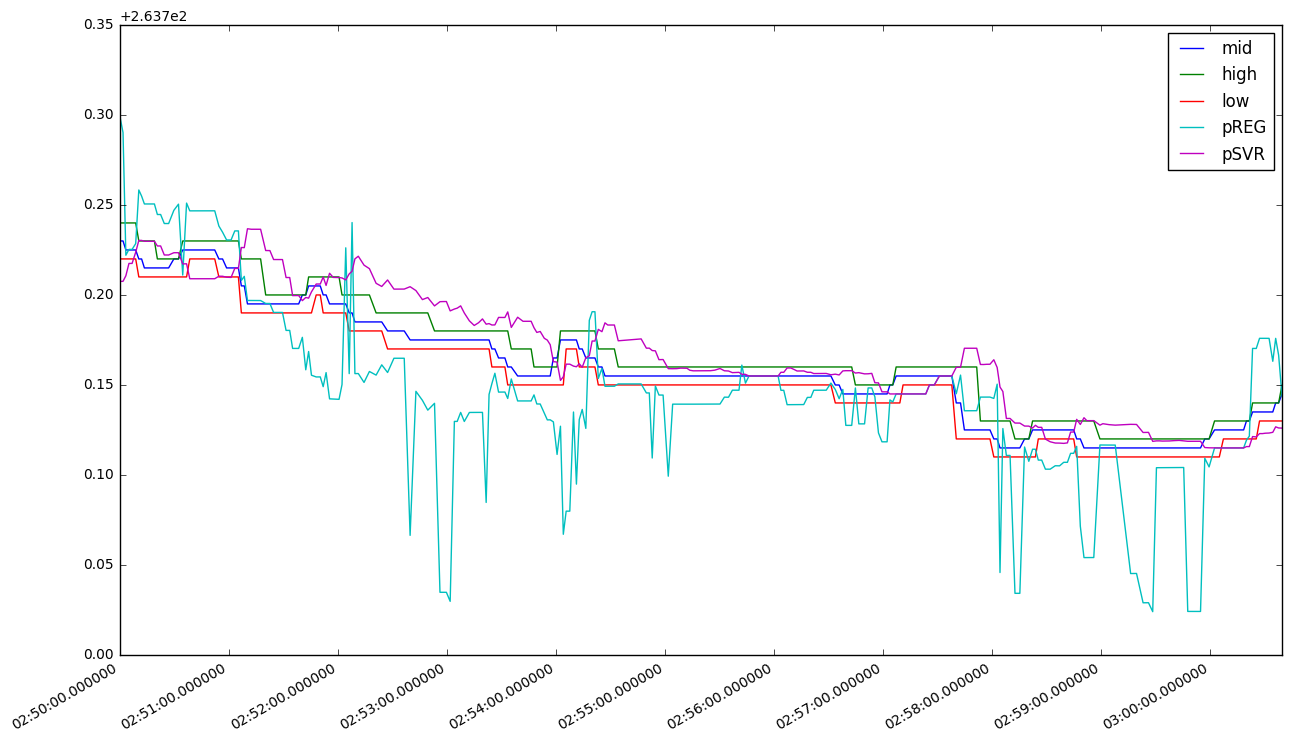

In [15]:
pdf[['mid','high','low','pREG','pSVR']].tail(300).plot(figsize=(15,9))
#df[['Volume']].tail(5000).plot(figsize=(15,9))
#data[['AvgVolume']].tail(5000).plot(figsize=(15,9))
plt.show()

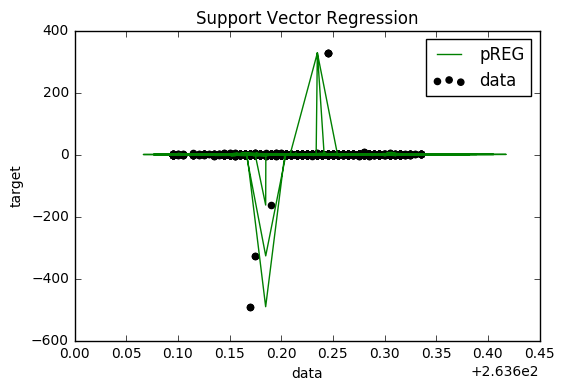

In [16]:
# look at the results
plt.scatter(pdf['mid'],test_y, c='k', label='data')
plt.hold('on')
plt.plot(pdf['pREG'],test_y, c='g', label='pREG')
#plt.plot(pdf['pSVR'], y, c='g', label='pSVR')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

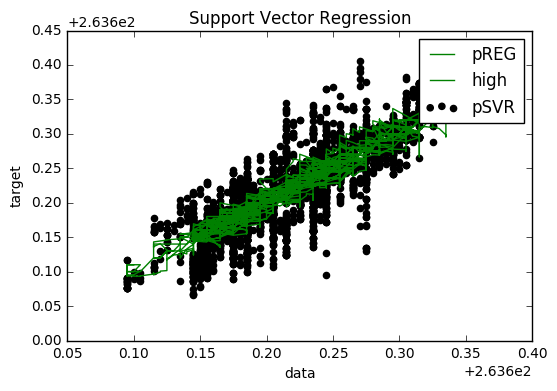

In [17]:
# look at the results
plt.scatter(pdf['mid'],pdf['pREG'], c='k', label='pSVR')
plt.hold('on')
plt.plot(pdf['mid'],pdf['pSVR'], c='g', label='pREG')
plt.plot(pdf['mid'], pdf['high'], c='g', label='high')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

#### ARCH

       
        https://www.quantopian.com/posts/some-code-from-ernie-chans-new-book-implemented-in-python
        http://auquan.com/cointegration-stationarity/
        https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
        http://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/
        https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing-Part-II
        https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c
        http://machinelearningmastery.com/time-series-data-stationary-python/

## Classification

In [18]:
X=df[['mid','vwap','spread','v','return','sigma','high','low',]]
y=df['mom']

In [19]:
len(df)

22308

In [20]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
#regr.fit(X.tail(20),y.tail(20))
#predict=regr.predict(X.tail(5))
regr.fit(X.dropna(),y.dropna())
predict=regr.predict(X)
#X=X.dropna()
#y=y.dropna()
#y[y == inf] = 0
dt=df[['mid']]
dt['predict']=predict
#dt['predict']=dt.mid+dt.mid*dt.predict
dt['predict']=dt.predict*df.v+df.mid.shift(12)
classify_df=df
classify_df['pREG']=dt.predict

from sklearn.svm import SVR
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.9) #kernel='linear' #kernel='poly'
predict_svr = svr_rbf.fit(X, y).predict(X)
dt1=df[['mid']]
dt1['predict']=predict_svr
dt1['predict']=dt1.predict*df.v+df.mid.shift(12)
classify_df['pSVR']=dt1.predict

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [21]:
def classification(df):
    mid1=(df.high+df.low)/2
    #flagUD=np.where(np.logical_and(df.mid>df.pREG,df.mid>df.pSVR),1,np.where(np.logical_and(df.mid<df.pREG,df.mid<df.pSVR),-1,0))
    #df['UD']= np.where(np.logical_and(df.mid>mid1,flagUD==1),1,np.where(np.logical_and(df.mid<mid1,flagUD==-1),-1,0))
    flagUD=np.where(np.logical_and(df.mid>df.pREG,df.mid>df.pSVR),1,np.where(np.logical_and(df.mid<df.pREG,df.mid<df.pSVR),-1,0))
    UD= np.where(np.logical_and(df.mid>mid1,flagUD==1),1,np.where(np.logical_and(df.mid<mid1,flagUD==-1),-1,0))
    df['U']= np.where(UD==1,1,0)
    df['D']= np.where(UD==-1,-1,0)
    df['UD']=df.U+df.D
    return df

In [22]:
data_class=classification(classify_df)
data_class=data_class.dropna()
df=df.dropna()
# both df and data_class have U,D,UD

In [23]:
data_class.head()

,mid,vwap,spread,v,mom,return,sigma,high,low,pREG,pSVR,U,D,UD
2017-12-07 20:13:02.022972,263.279999,263.279999,0.000000,0.029999,0.499491,0.000000,0.004526,263.279999,263.269989,263.283575,263.272316,0,0,0
2017-12-07 20:13:02.331537,263.285004,263.289734,0.004730,0.035004,0.571055,0.000038,0.004278,263.290009,263.269989,263.251007,263.273346,1,0,1
2017-12-07 20:13:02.624627,263.285004,263.287781,0.002777,0.035004,0.571055,0.000038,0.004181,263.290009,263.269989,263.254913,263.272560,1,0,1
2017-12-07 20:13:02.914310,263.285004,263.287781,0.002777,0.035004,0.571055,0.000038,0.004070,263.290009,263.279999,263.265739,263.271821,0,0,0
2017-12-07 20:13:03.218062,263.285004,263.287781,0.002777,0.035004,0.571055,0.000038,0.004069,263.290009,263.279999,263.265736,263.271821,0,0,0


In [24]:
df.head()

,mid,vwap,spread,v,mom,return,sigma,high,low,pREG,pSVR,U,D,UD
2017-12-07 20:13:02.022972,263.279999,263.279999,0.000000,0.029999,0.499491,0.000000,0.004526,263.279999,263.269989,263.283575,263.272316,0,0,0
2017-12-07 20:13:02.331537,263.285004,263.289734,0.004730,0.035004,0.571055,0.000038,0.004278,263.290009,263.269989,263.251007,263.273346,1,0,1
2017-12-07 20:13:02.624627,263.285004,263.287781,0.002777,0.035004,0.571055,0.000038,0.004181,263.290009,263.269989,263.254913,263.272560,1,0,1
2017-12-07 20:13:02.914310,263.285004,263.287781,0.002777,0.035004,0.571055,0.000038,0.004070,263.290009,263.279999,263.265739,263.271821,0,0,0
2017-12-07 20:13:03.218062,263.285004,263.287781,0.002777,0.035004,0.571055,0.000038,0.004069,263.290009,263.279999,263.265736,263.271821,0,0,0


In [25]:
# split into train and test sets
train_size = int(len(data_class) * 0.80)
test_size = len(data_class) - train_size
train= data_class[0:train_size]
test= data_class[train_size:len(data_class)]
print(len(train), len(test))

17836 4460


In [26]:
train_X=train[['mid','vwap','spread','v','return','sigma','high','low','mom','pREG','pSVR']]
train_y=train['UD']
test_X=test[['mid','vwap','spread','v','return','sigma','high','low','mom','pREG','pSVR']]
test_y=test['UD']
train_U=train['U']
test_U=test['U']
train_D=train['D']
test_D=test['D']

In [27]:
print(len(train_U), len(test_U))

17836 4460


## Logistic Regression

In [28]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [29]:
model = LogisticRegression()
model.fit(train_X,train_U)
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [30]:
# make predictions
expected =test_U
predicted = model.predict(test_X)

In [31]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92      3778
          1       0.00      0.00      0.00       682

avg / total       0.72      0.85      0.78      4460

[[3778    0]
 [ 682    0]]


/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
model = LogisticRegression()
model.fit(train_X,train_D)
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [33]:
# make predictions
expected =test_D
predicted = model.predict(test_X)

In [34]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00       745
          0       0.83      1.00      0.91      3715

avg / total       0.69      0.83      0.76      4460

[[   0  745]
 [   0 3715]]


/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision Trees

In [35]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [36]:
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(train_X,train_U)
print(model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [37]:
# make predictions
expected =test_U
predicted = model.predict(test_X)

In [38]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.91      0.86      0.88      3778
          1       0.40      0.50      0.44       682

avg / total       0.83      0.81      0.82      4460

[[3263  515]
 [ 340  342]]


In [39]:
accuracy =model.score(test_X,test_U) 
accuracy

0.80829596412556048

In [40]:
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(train_X,train_D)
print(model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [41]:
# make predictions
expected =test_D
predicted = model.predict(test_X)

In [42]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

         -1       0.41      0.40      0.41       745
          0       0.88      0.88      0.88      3715

avg / total       0.80      0.80      0.80      4460

[[ 301  444]
 [ 432 3283]]


In [43]:
accuracy =model.score(test_X,test_D) 
accuracy

0.80358744394618831

### Random Forest

The random forest algorithm can find nonlinearities in data that a linear regression wouldn’t be able to pick up on.


In [44]:
# Import the random forest model.
from sklearn.ensemble import RandomForestRegressor

In [45]:
# Initialize the model with some parameters.
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=1)
# Fit the model to the data.
model.fit(train_X,train_U)
print(model)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)


In [46]:
# Make predictions.
expected=test_U
predicted = model.predict(test_X)

In [47]:
accuracy =model.score(test_X,test_U) 
accuracy

0.2186929305446812

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(train_X,train_U)
accuracy = clf.score(test_X,test_U)
print(accuracy)

0.862556053812


### KNN

In [50]:
from sklearn import neighbors

In [51]:
clf = neighbors.KNeighborsClassifier()
clf.fit(train_X,train_U)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [52]:
accuracy = clf.score(test_X,test_U)
print(accuracy)

0.828475336323


### Ada Boosting binary Classification

In [53]:
from sklearn.ensemble import AdaBoostClassifier

In [54]:
clf = AdaBoostClassifier()
clf.fit(train_X,train_U)
accuracy = clf.score(test_X,test_U)
print(accuracy)

0.847085201794


### Gradient Tree Boosting binary Classification

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

In [56]:
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(train_X,train_U)
accuracy = clf.score(test_X,test_U)
print(accuracy)

0.845739910314


### Quadratic Discriminant Analysis binary Classification

In [57]:
from sklearn.qda import QDA

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [58]:
clf = QDA()
clf.fit(train_X,train_U)
accuracy = clf.score(test_X,test_U)
print(accuracy)

0.906950672646


/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:694: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### SVM

SVM (Support Vector Machines) is one of the most popular machine learning algorithms used mainly for the classification problem. As well as logistic regression, SVM allows multi-class classification with the help of the one-vs-all method.

In [59]:
from sklearn import metrics
from sklearn.svm import SVC

In [60]:
# fit a SVM model to the data
model = SVC()
model.fit(train_X,train_U)
print(model)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [61]:
# Make predictions.
expected=test_U
predicted = model.predict(test_X)

In [62]:
accuracy =model.score(test_X,test_U) 
accuracy

0.84618834080717487

In [63]:
# fit a SVM model to the data
model = SVC()
model.fit(train_X,train_D)
print(model)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [64]:
# Make predictions.
expected=test_D
predicted = model.predict(test_X)

In [65]:
accuracy =model.score(test_X,test_D) 
accuracy

0.83340807174887888

### Saving

In [ ]:
    
    if savemodel == True:
        fname_out = '{}-{}.pickle'.format(fout, datetime.now())
        with open(fname_out, 'wb') as f:
            cPickle.dump(clf, f, -1)    

### graphical

In [66]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
#plt.rcParams['figure.figsize'] = 8,6

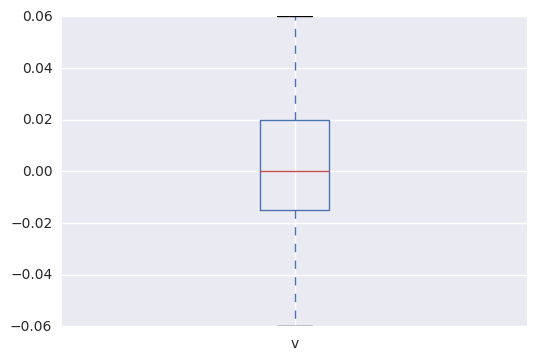

In [67]:
test.boxplot(column='v')

(245, 248)

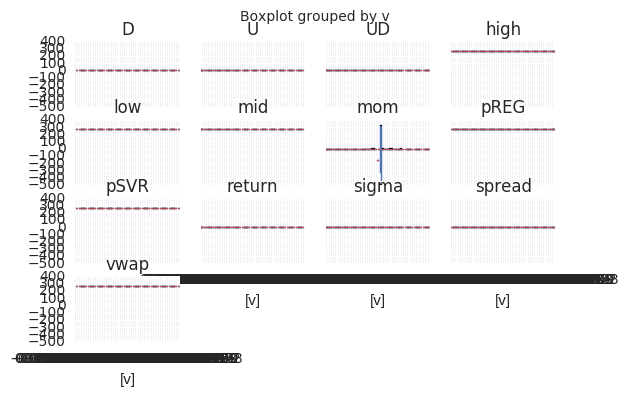

In [68]:
test.boxplot(by='v')
plt.ylim(245,248)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6922740f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc69242b2b0>]], dtype=object)

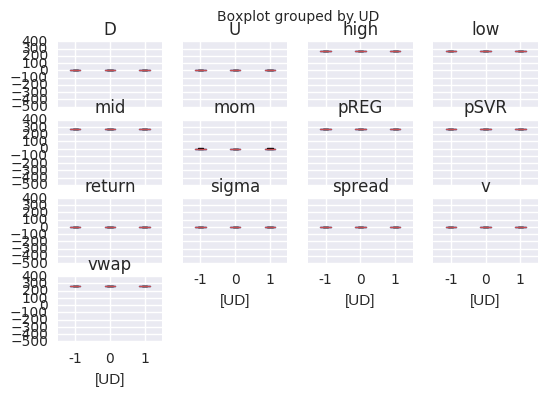

In [69]:
test.boxplot(by='UD')

In [70]:
#some descriptive statistics
test.describe()

,mid,vwap,spread,v,mom,return,sigma,high,low,pREG,pSVR,U,D,UD
count,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000,4460.000000
mean,263.819397,263.818878,0.000462,0.001618,0.043287,0.000038,0.003904,263.826193,263.812398,263.819161,263.819042,0.152915,-0.167040,-0.014126
std,0.045108,0.045403,0.004088,0.022001,16.100435,0.000014,0.000536,0.045081,0.045367,0.047122,0.045793,0.359946,0.373054,0.565533
min,263.695007,263.690155,-0.014099,-0.059998,-491.000000,-0.000114,0.001829,263.700012,263.690002,263.688131,263.692728,0.000000,-1.000000,-1.000000
25%,263.785004,263.785004,-0.003662,-0.014984,0.000000,0.000038,0.003552,263.790009,263.779999,263.784778,263.784078,0.000000,0.000000,0.000000
50%,263.825012,263.821335,0.000122,0.000000,0.000000,0.000038,0.003917,263.829987,263.820007,263.820413,263.822422,0.000000,0.000000,0.000000
75%,263.854980,263.850197,0.004272,0.019989,0.500000,0.000038,0.004261,263.859985,263.839996,263.851297,263.851654,0.000000,0.000000,0.000000
max,263.934998,263.939789,0.019836,0.059998,328.000000,0.000152,0.005719,263.940002,263.929993,263.969920,263.945954,1.000000,0.000000,1.000000


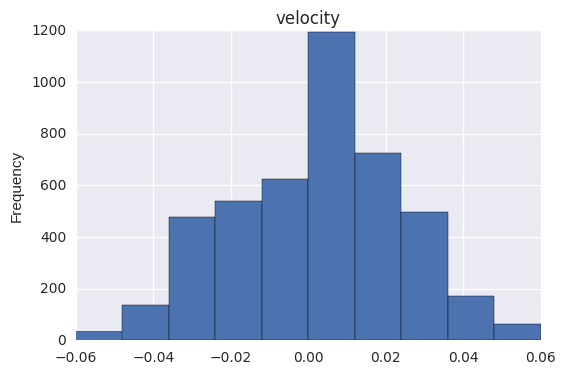

In [71]:
test['v'].plot(kind='hist', grid=True, title='velocity')

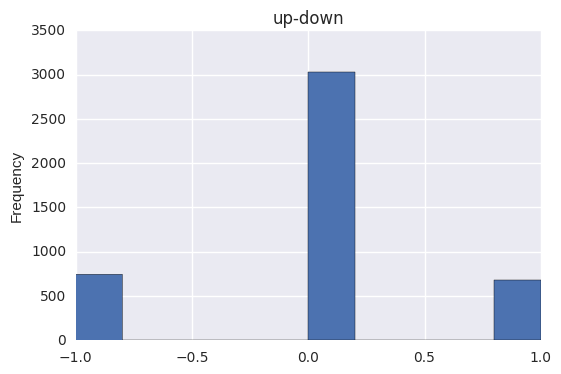

In [72]:
test['UD'].plot(kind='hist', grid=True, title='up-down')

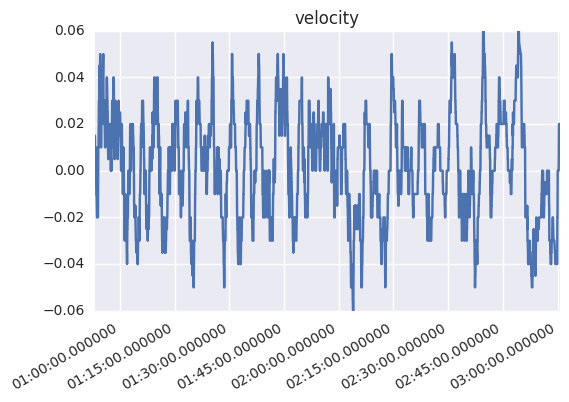

In [73]:
test['v'].plot(kind='line', grid=True, title='velocity')

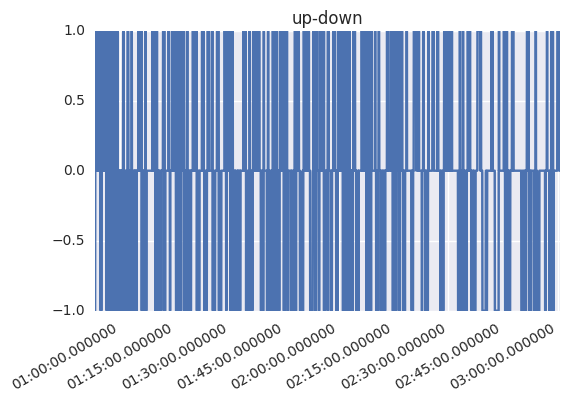

In [74]:
test['UD'].plot(kind='line', grid=True, title='up-down')

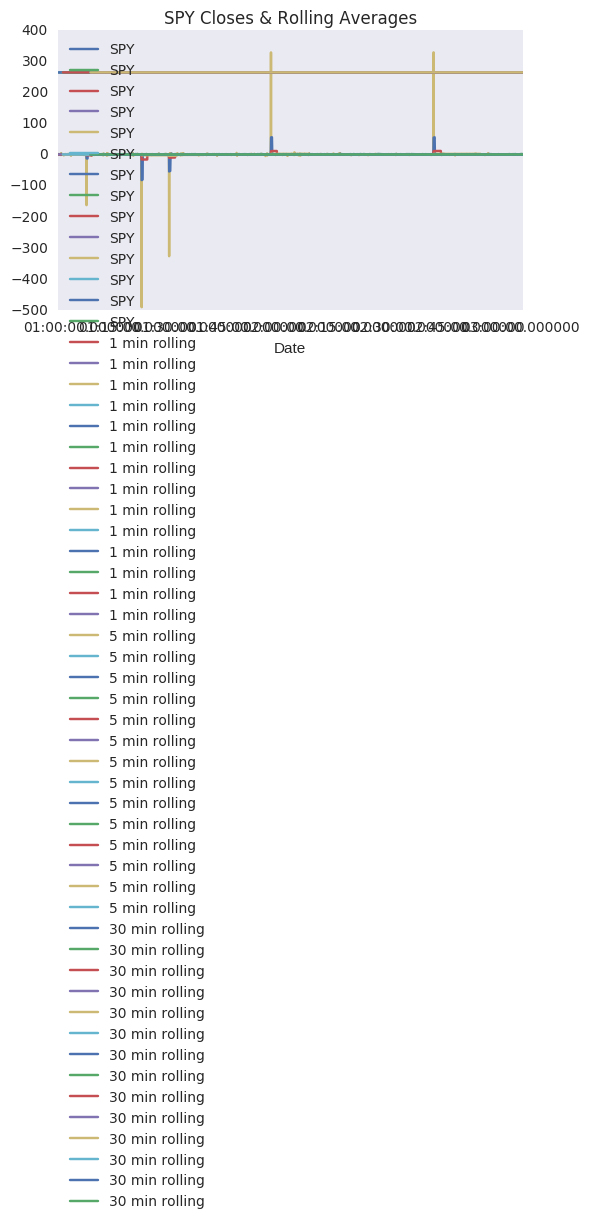

In [75]:
# Find 7, 30, 120 day moving averages (very broadly, rolling week, month and quarter)
spy_12 = test.rolling(window=12).mean()
spy_60 = test.rolling(window=60).mean()
spy_360 = test.rolling(window=360).mean()

fig = plt.figure()
fig.autofmt_xdate()
ax = fig.add_subplot(1,1,1)
ax.plot(test.index,test, label='SPY')
ax.plot(spy_12.index, spy_12, label='1 min rolling')
ax.plot(spy_60.index, spy_60, label='5 min rolling')
ax.plot(spy_360.index,spy_360, label='30 min rolling')
ax.grid()
ax.legend(loc=2)
ax.set_xlabel('Date')
plt.title('SPY Closes & Rolling Averages')
plt.show()

In [76]:
#frequency
round(test['mom']).value_counts()

 0.0      2925
 1.0       823
-1.0       427
 2.0       115
-2.0        80
 3.0        24
 4.0        19
-3.0        17
-4.0        14
 328.0       4
 5.0         2
-491.0       2
 7.0         2
 6.0         2
-327.0       2
-5.0         1
-163.0       1
Name: mom, dtype: int64

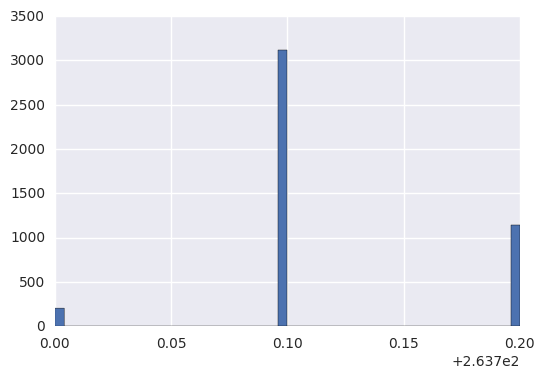

In [77]:
round(test['vwap'],1).hist(bins=50)

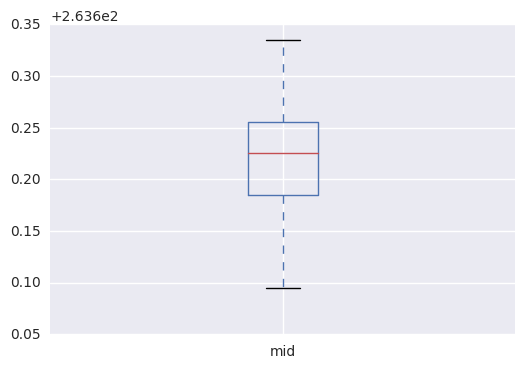

In [78]:
test.boxplot(column='mid')

In [79]:
#df for datascience
#signal=df.DataFrame(data=df.mid)
signal=df
#df['time']=df.index.strftime('%H:%M:%S')
time=signal.index.strftime('%H:%M:%S')

In [80]:
P=(signal.high+signal.low+signal.mid)/3
signal['UT']=(P+signal.high.rolling(60).max()-signal.low.rolling(60).max())
signal['DT']=(P-signal.high.rolling(60).min()+signal.low.rolling(60).min())
signal['BS']=np.where(signal.mid<=df.DT,"B",np.where(signal.mid>=df.UT,"S","H"))
signal=signal.dropna()

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [81]:
signal.head()

,mid,vwap,spread,v,mom,return,sigma,high,low,pREG,pSVR,U,D,UD,UT,DT,BS
2017-12-07 20:13:21.961187,263.285004,263.289917,0.004913,0.005005,3.993902,0.000038,0.004073,263.290009,263.269989,263.262530,263.265599,1,0,1,263.291646,263.271688,H
2017-12-07 20:13:22.348174,263.285004,263.289673,0.004669,0.005005,3.993902,0.000038,0.004083,263.290009,263.269989,263.262612,263.265599,1,0,1,263.291646,263.271688,H
2017-12-07 20:13:22.720406,263.285004,263.289673,0.004669,0.000000,0.000000,0.000038,0.004082,263.290009,263.279999,263.269989,263.269989,0,0,0,263.294983,263.275024,H
2017-12-07 20:13:23.092605,263.285004,263.289673,0.004669,0.000000,0.000000,0.000038,0.004096,263.290009,263.279999,263.269989,263.269989,0,0,0,263.294983,263.275024,H
2017-12-07 20:13:23.408679,263.290009,263.290009,0.000000,0.005005,3.000000,0.000038,0.004102,263.290009,263.279999,263.275195,263.275721,1,0,1,263.296651,263.276693,H


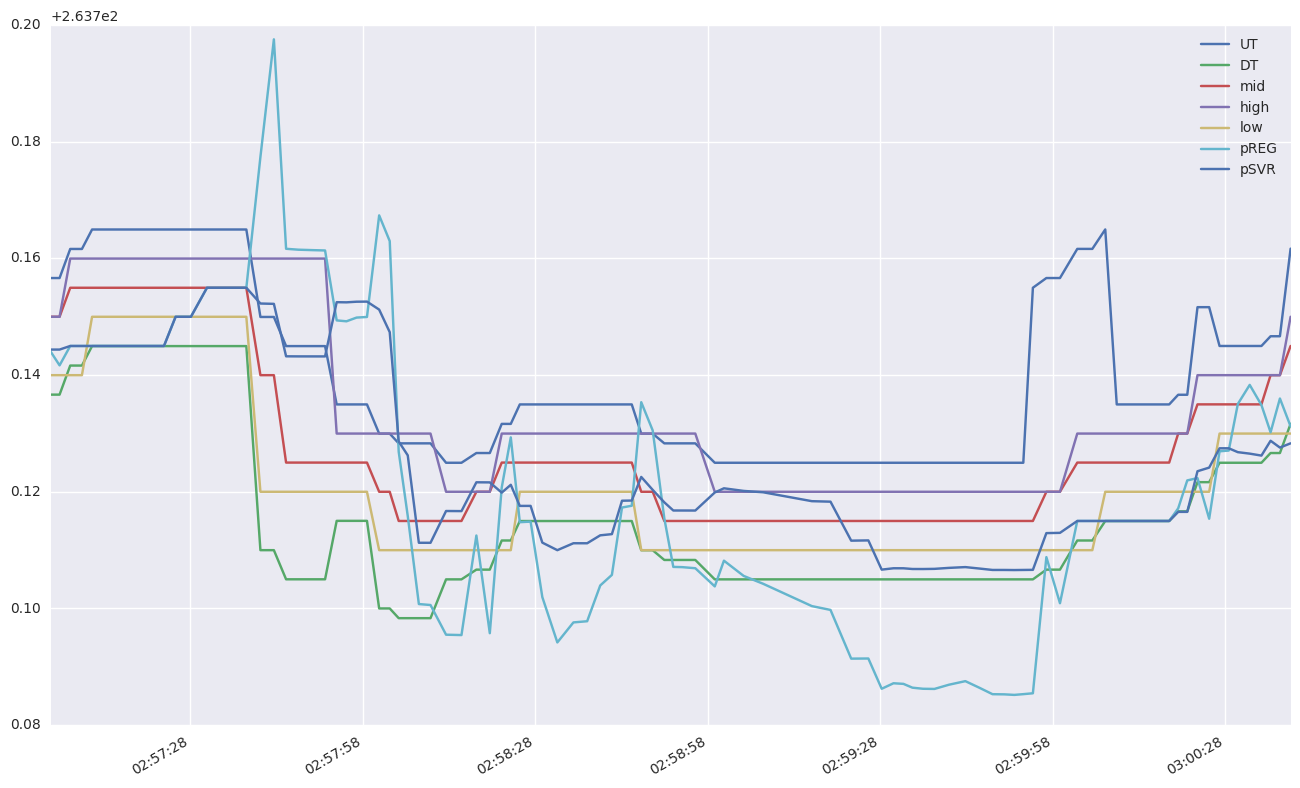

In [82]:


df[['UT','DT','mid','high','low','pREG','pSVR']].tail(100).plot(figsize=(16, 10))
plt.show()



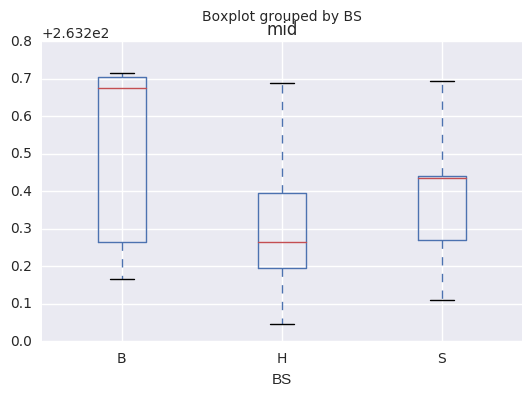

In [83]:
signal.boxplot(column='mid',by ='BS')

In [84]:
temp1 = round(signal['UD']).value_counts(ascending=True)
temp2 = signal.pivot_table(values='UD',index=['BS'],aggfunc=lambda x: x.map({'B':1,'S':-1,'H':0}).mean())

In [85]:
print ('Frequency Table for spread:')
print (temp1)
print ('\nProbility') 
print (temp2.tail())

Frequency Table for spread:
 1     3614
-1     3737
 0    14886
Name: UD, dtype: int64

Probility
Empty DataFrame
Columns: []
Index: [B, H, S]


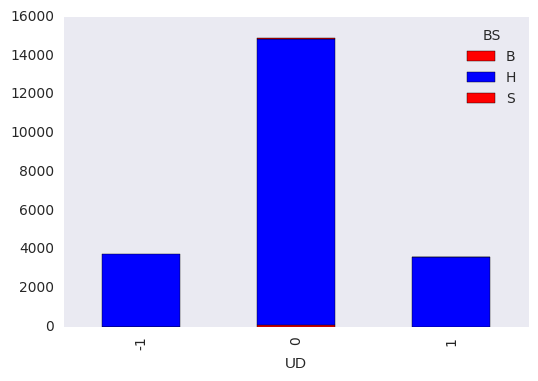

In [86]:
temp3 = pd.crosstab(round(signal['UD']),signal['BS'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

In [87]:
# number of missing values in each column as isnull() returns 1, if the value is null.
signal.apply(lambda x: sum(x.isnull()),axis=0)

mid       0
vwap      0
spread    0
v         0
mom       0
return    0
sigma     0
high      0
low       0
pREG      0
pSVR      0
U         0
D         0
UD        0
UT        0
DT        0
BS        0
dtype: int64

In [88]:
signal['BS'].value_counts()

H    22105
B       90
S       42
Name: BS, dtype: int64

In [89]:
signal['UD'].value_counts()

 0    14886
-1     3737
 1     3614
Name: UD, dtype: int64

In [90]:
table = signal.pivot_table(values='v', index='BS' ,columns='UD', aggfunc=np.median)
print(table)

UD        -1         0         1
BS                              
B   0.039978  0.010010       NaN
H  -0.004974  0.000000  0.005005
S        NaN  0.017517  0.022491


In [91]:
#Boolean indexing
signal.loc[(signal['v']<0) & (signal["BS"]=="B") & (signal["DT"]>signal["mid"]), ['mid',"spread","BS","DT"]].head()

,mid,spread,BS,DT
2017-12-07 22:21:27.635876,263.459991,0.0,B,263.463328
2017-12-07 22:21:28.585295,263.459991,0.0,B,263.463328
2017-12-07 22:21:29.549998,263.459991,0.0,B,263.463328


In [101]:
train_X.head()

,mid,vwap,spread,v,return,sigma,high,low,mom,pREG,pSVR
2017-12-07 20:13:02.022972,263.279999,263.279999,0.000000,0.029999,0.000000,0.004526,263.279999,263.269989,0.499491,263.283575,263.272316
2017-12-07 20:13:02.331537,263.285004,263.289734,0.004730,0.035004,0.000038,0.004278,263.290009,263.269989,0.571055,263.251007,263.273346
2017-12-07 20:13:02.624627,263.285004,263.287781,0.002777,0.035004,0.000038,0.004181,263.290009,263.269989,0.571055,263.254913,263.272560
2017-12-07 20:13:02.914310,263.285004,263.287781,0.002777,0.035004,0.000038,0.004070,263.290009,263.279999,0.571055,263.265739,263.271821
2017-12-07 20:13:03.218062,263.285004,263.287781,0.002777,0.035004,0.000038,0.004069,263.290009,263.279999,0.571055,263.265736,263.271821


In [93]:
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense
import numpy

Using TensorFlow backend.


In [102]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=11, init='uniform', activation='relu'))
model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(train_X,train_U, nb_epoch=11, batch_size=10)
# evaluate the model
scores = model.evaluate(test_X,test_U)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/11


KeyError: '[11246  2182  4681 16448 11991 13882  2347 15909 13215  7383] not in index'